In [167]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

X = np.load('../Dvara/X_10_2_re.npy')
y = np.load('../Dvara/y_10_2_re.npy')
#y = (X[:,-1,-1]>=5)*1

In [168]:
ind_pass1 = np.isnan(X).sum(axis=1).sum(axis=1)
ind_pass2 = [i==0 for i in ind_pass1]

In [169]:
X = X[ind_pass2]
y = y[ind_pass2]

In [539]:
req_cols = ['active_loans_count', 'opened_loans_count', 'closed_loans_count', 'churn', 'outstanding_loans_end', 'cross_bor', 'outstanding_loans_beginning', 'income_annual', 'expense_quarter', 'emi', 'dpd']

# acc_cols = [7,8,10]
# X = X[:,:,acc_cols]

col1 = [0,1,2,3,4,5,6]
col2 = [7,8,9]
col3 = [10]

In [568]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Input, Dropout, Lambda, TimeDistributed, Concatenate, Maximum
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

X_train1 = X_train[:,:,col1]
X_train2 = X_train[:,:,col2]
X_train3 = (X_train[:,:,col3]>=5)*1

X_test1 = X_test[:,:,col1]
X_test2 = X_test[:,:,col2]
X_test3 = (X_test[:,:,col3]>=5)*1

In [569]:
import keras.backend as K

In [570]:
from keras.regularizers import l2

inp1 = Input(shape=(X_train1.shape[1], X_train1.shape[2]))
inp2 = Input(shape=(X_train2.shape[1], X_train2.shape[2]))
inp3 = Input(shape=(X_train3.shape[1], X_train3.shape[2]))

layer1_1 = LSTM(64, activation='tanh', recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.000001))(inp1)
layer2_1 = GRU(32, activation='tanh', recurrent_dropout=0.3, kernel_regularizer=l2(0.000001))(layer1_1)

layer1_2 = LSTM(64, activation='tanh', recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.000001))(inp2)
layer2_2 = GRU(32, activation='tanh', recurrent_dropout=0.3, kernel_regularizer=l2(0.000001))(layer1_2)

layer1_3 = LSTM(64, activation='tanh', recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.000001))(inp3)
layer2_3 = GRU(64, activation='tanh', recurrent_dropout=0.3, kernel_regularizer=l2(0.000001))(layer1_3)

layer2 = Concatenate()([layer2_1, layer2_2])
layer3 = Maximum()([layer2, layer2_3])

layer4 = Dropout(0.4)(layer3)
layer5 = Dense(32, activation = 'tanh')(layer4)
layer6 = Dropout(0.4)(layer5)
layer7 = Dense(8, activation='tanh')(layer6)
out = Dense(1, activation = 'sigmoid')(layer7)

model = Model(inputs=[inp1, inp2, inp3], outputs=out)

In [571]:
def custom_loss(layer):

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return K.binary_crossentropy(y_true, y_pred) + 5*K.mean(layer[:,-1,0]*K.square(y_pred - layer[:,-1,0]), axis=-1)
        #return K.mean(K.square(y_pred - y_true) + layer[:,-1,0]*K.square(y_pred - layer[:,-1,0]), axis=-1)
        #return K.mean(K.square(y_pred - y_true) + 10*y_true*K.square(y_pred - y_true), axis=-1)
   
    # Return a function
    return loss

In [572]:
model.compile(optimizer='adam',
          loss=custom_loss(inp3),
          metrics=['accuracy'])

In [573]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 10, 7)        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 10, 3)        0                                            
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 10, 64)       18432       input_19[0][0]                   
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 10, 64)       17408       input_20[0][0]                   
__________________________________________________________________________________________________
input_21 (

In [574]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
model.fit([X_train1, X_train2, X_train3], y_train, batch_size = 1024, epochs=100, validation_data=[[X_test1, X_test2, X_test3], y_test], shuffle=True, callbacks=callbacks)

Train on 63322 samples, validate on 27138 samples
Epoch 1/100
63322/63322 [==============================] - 114s 2ms/step - loss: 0.9779 - acc: 0.7176 - val_loss: 0.9318 - val_acc: 0.8914
Epoch 2/100
63322/63322 [==============================] - 112s 2ms/step - loss: 0.9277 - acc: 0.8926 - val_loss: 0.9144 - val_acc: 0.9261
Epoch 3/100
63322/63322 [==============================] - 114s 2ms/step - loss: 0.9130 - acc: 0.9280 - val_loss: 0.9084 - val_acc: 0.9337
Epoch 4/100
63322/63322 [==============================] - 115s 2ms/step - loss: 0.9086 - acc: 0.9337 - val_loss: 0.9055 - val_acc: 0.9397
Epoch 5/100
63322/63322 [==============================] - 114s 2ms/step - loss: 0.9070 - acc: 0.9357 - val_loss: 0.9045 - val_acc: 0.9476
Epoch 6/100
63322/63322 [==============================] - 115s 2ms/step - loss: 0.9063 - acc: 0.9352 - val_loss: 0.9038 - val_acc: 0.9507
Epoch 7/100
63322/63322 [==============================] - 115s 2ms/step - loss: 0.9052 - acc: 0.9407 - val_loss: 0.

In [575]:
# Predict and get lables for the test data
y_test_pred = (model.predict([X_test1, X_test2, X_test3])>=0.5)*1

In [576]:
# model.save("rnn_pu_learning_model.h5")

In [577]:
# Import packages for calculating metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest F1 score:\n", classification_report(y_test, y_test_pred))
print("\nTest confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.9453902277249613

Test F1 score:
              precision    recall  f1-score   support

        0.0       0.98      0.95      0.96     21279
        1.0       0.85      0.91      0.88      5859

avg / total       0.95      0.95      0.95     27138


Test confusion matrix:
 [[20301   978]
 [  504  5355]]


### Validation

In [578]:
n = 1
X_knn_val = np.load('Validation_Dataset_for_Autoencoder.npy')
y_knn_val_new = ((X_knn_val[:,-n:,-1]>=5).sum(axis=1)>=1)*1
#arr_hhs = np.load('val_labels.npy')

In [579]:
arr_hhs = np.load('val_labels.npy')

In [580]:
len(arr_hhs)

1508

In [581]:
# for i in range(len(y_knn_val_new)):
#     if y_knn_val_new[i]==1:
#         arr_hhs[i]=1

In [582]:
ind_rej = np.logical_and(arr_hhs==0, y_knn_val_new==1)
ind_pass = [i==False for i in ind_rej]

In [583]:
X_knn_val = X_knn_val[ind_pass,:,:]
y_knn_val_new = y_knn_val_new[ind_pass]
arr_hhs = arr_hhs[ind_pass]

In [584]:
X_knn_val1 = X_knn_val[:,:,col1]
X_knn_val2 = X_knn_val[:,:,col2]
X_knn_val3 = (X_knn_val[:,:,col3]>=5)*1

In [585]:
val_pred_prob = model.predict([X_knn_val1, X_knn_val2, X_knn_val3])

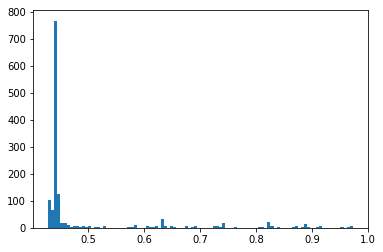

In [586]:
plt.hist(val_pred_prob, bins=100)
plt.show()

In [602]:
val_pred = (val_pred_prob>=0.45)*1

In [603]:
for i in range(len(y_knn_val_new)):
    if y_knn_val_new[i] == 1:
        val_pred[i] = 1

In [604]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(arr_hhs, val_pred))
print("\nTest F1 score:\n", classification_report(arr_hhs, val_pred))
print("\nTest confusion matrix:\n", confusion_matrix(arr_hhs, val_pred))

Test Accuracy: 0.487627365356623

Test F1 score:
              precision    recall  f1-score   support

          0       0.39      0.89      0.54       461
          1       0.83      0.29      0.43       913

avg / total       0.68      0.49      0.46      1374


Test confusion matrix:
 [[408  53]
 [651 262]]


In [605]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(arr_hhs, y_knn_val_new))
print("\nTest F1 score:\n", classification_report(arr_hhs, y_knn_val_new))
print("\nTest confusion matrix:\n", confusion_matrix(arr_hhs, y_knn_val_new))

Test Accuracy: 0.4737991266375546

Test F1 score:
              precision    recall  f1-score   support

          0       0.39      1.00      0.56       461
          1       1.00      0.21      0.34       913

avg / total       0.80      0.47      0.42      1374


Test confusion matrix:
 [[461   0]
 [723 190]]


### Performance on RNN wo PU on distress

In [426]:
from keras.models import load_model
rnn_model = load_model('../Dvara/rnn_best_model3.h5')

In [438]:
X_knn_val1 = X_knn_val[:,:,col1]
X_knn_val2 = X_knn_val[:,:,col2]
X_knn_val3 = X_knn_val[:,:,col3]

val_pred_prob = rnn_model.predict([X_knn_val1, X_knn_val2, X_knn_val3])

In [439]:
val_pred = (val_pred_prob>=0.5)*1

In [440]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(arr_hhs, val_pred))
print("\nTest F1 score:\n", classification_report(arr_hhs, val_pred))
print("\nTest confusion matrix:\n", confusion_matrix(arr_hhs, val_pred))

Test Accuracy: 0.42358078602620086

Test F1 score:
              precision    recall  f1-score   support

          0       0.37      1.00      0.54       461
          1       0.99      0.13      0.24       913

avg / total       0.78      0.42      0.34      1374


Test confusion matrix:
 [[460   1]
 [791 122]]


### Performance of PU learning model where dpd 10 q is less than 999

In [507]:
X = np.load('../Dvara/X_10_2_re.npy')
y = np.load('../Dvara/y_10_2_re.npy')

ind_pass1 = np.isnan(X).sum(axis=1).sum(axis=1)
ind_pass2 = [i==0 for i in ind_pass1]

X = X[ind_pass2]
y = y[ind_pass2]

dpd_pass = X[:,-1,-1]<999
X_pass = X[dpd_pass,:,:]
y_pass = y[dpd_pass]

X_pass1 = X_pass[:,:,col1]
X_pass2 = X_pass[:,:,col2]
X_pass3 = X_pass[:,:,col3]

val_pred_prob = rnn_model.predict([X_pass1, X_pass2, X_pass3])

In [508]:
val_pred = (val_pred_prob>=0.5)*1

In [509]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(y_pass, val_pred))
print("\nTest F1 score:\n", classification_report(y_pass, val_pred))
print("\nTest confusion matrix:\n", confusion_matrix(y_pass, val_pred))

Test Accuracy: 0.9629620762306071

Test F1 score:
              precision    recall  f1-score   support

        0.0       0.97      0.99      0.98     70920
        1.0       0.92      0.83      0.87     12616

avg / total       0.96      0.96      0.96     83536


Test confusion matrix:
 [[70006   914]
 [ 2180 10436]]


In [511]:
(y_pass==1).sum()/y_pass.shape[0]

0.151024707910362

### Performance of rnn model where dpd 10 q is less than t

In [469]:
X = np.load('../Dvara/X_10_2_re.npy')
y = np.load('../Dvara/y_10_2_re.npy')

ind_pass1 = np.isnan(X).sum(axis=1).sum(axis=1)
ind_pass2 = [i==0 for i in ind_pass1]

X = X[ind_pass2]
y = y[ind_pass2]

dpd_pass = X[:,-1,-1]<90
X_pass = X[dpd_pass,:,:]
y_pass = y[dpd_pass]

X_pass1 = X_pass[:,:,col1]
X_pass2 = X_pass[:,:,col2]
X_pass3 = X_pass[:,:,col3]

val_pred_prob = rnn_model.predict([X_pass1, X_pass2, X_pass3])

In [483]:
val_pred = (val_pred_prob>=0.5)*1

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(y_pass, val_pred))
print("\nTest F1 score:\n", classification_report(y_pass, val_pred))
print("\nTest confusion matrix:\n", confusion_matrix(y_pass, val_pred))

Test Accuracy: 0.9677578009727308

Test F1 score:
              precision    recall  f1-score   support

        0.0       0.97      1.00      0.98     69746
        1.0       0.81      0.41      0.55      3450

avg / total       0.96      0.97      0.96     73196


Test confusion matrix:
 [[69422   324]
 [ 2036  1414]]


In [484]:
(y_pass==1).sum()/y_pass.shape[0]

0.047133723154270724

### Performnace of q10 del

In [505]:
val_pred = (X[:,-1,-1]>=5)*1

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(y, val_pred))
print("\nTest F1 score:\n", classification_report(y, val_pred))
print("\nTest confusion matrix:\n", confusion_matrix(y, val_pred))

Test Accuracy: 0.9518129560026531

Test F1 score:
              precision    recall  f1-score   support

        0.0       0.97      0.96      0.97     71148
        1.0       0.87      0.91      0.89     19312

avg / total       0.95      0.95      0.95     90460


Test confusion matrix:
 [[68618  2530]
 [ 1829 17483]]


In [506]:
X1 = X[:,:,col1]
X2 = X[:,:,col2]
X3 = X[:,:,col3]
val_pred_prob = rnn_model.predict([X1, X2, X3])
val_pred = (val_pred_prob>=0.5)*1

print("Test Accuracy:", accuracy_score(y, val_pred))
print("\nTest F1 score:\n", classification_report(y, val_pred))
print("\nTest confusion matrix:\n", confusion_matrix(y, val_pred))

Test Accuracy: 0.9634866239221755

Test F1 score:
              precision    recall  f1-score   support

        0.0       0.97      0.98      0.98     71148
        1.0       0.94      0.89      0.91     19312

avg / total       0.96      0.96      0.96     90460


Test confusion matrix:
 [[70038  1110]
 [ 2193 17119]]
